In [14]:
# First things first we import our libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql.types import IntegerType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, udf, when, isnan, isnull, mean, count, desc
import numpy as np
from IPython.display import Image
from IPython.display import display
from pyspark.sql import Row
from numpy import linalg as LA
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Here printing my computer's info
import socket

hostname = socket.gethostname()
ip_address = socket.gethostbyname(hostname)

print(f"Hostname: {hostname}")
print(f"IP Address: {ip_address}")


Hostname: DESKTOP-Q2FUPDM
IP Address: 192.168.1.12


In [3]:
# Again more computer info
import platform

print(f"System: {platform.system()}")
print(f"Node: {platform.node()}")
print(f"Release: {platform.release()}")
print(f"Version: {platform.version()}")
print(f"Machine: {platform.machine()}")
print(f"Processor: {platform.processor()}")


System: Windows
Node: DESKTOP-Q2FUPDM
Release: 10
Version: 10.0.19045
Machine: AMD64
Processor: Intel64 Family 6 Model 165 Stepping 2, GenuineIntel


In [4]:
# Creating the Spark session with modifiers so we can use our system better
conf = SparkConf() \
    .setMaster("local[3]") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g") \
    .set("spark.executor.cores", "3") \

# Check if SparkContext is already created, otherwise create it
if not SparkContext._active_spark_context:
    sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName("AnimeRecommendation").getOrCreate()

In [5]:
# Setting the directory so we can access our .csv files
directory = "dataset"

In [6]:
# Reading the dataset we are going to work on
anime_data = spark.read.csv(directory+"/anime.csv", inferSchema = True, header = True)
rating_data = spark.read.csv(directory+"/rating.csv", inferSchema = True, header = True)

+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|
|    9969|       Gintama&#039;|Action, Comedy, H...|   TV|      51|  9.16| 151266|
|   32935|Haikyuu!!: Karasu...|Comedy, Drama, Sc...|   TV|      10|  9.15|  93351|
|   11061|Hunter x Hunter (...|Action, Adventure...|   TV|     148|  9.13| 425855|
|     820|Ginga Eiyuu Densetsu|Drama, Military, ...|  OVA|     110|  9.11|  80679|
|   15335|Gintama Movie: Ka...|Action, Comedy, H...|Movie|       1|   9.1|  72534|
|   

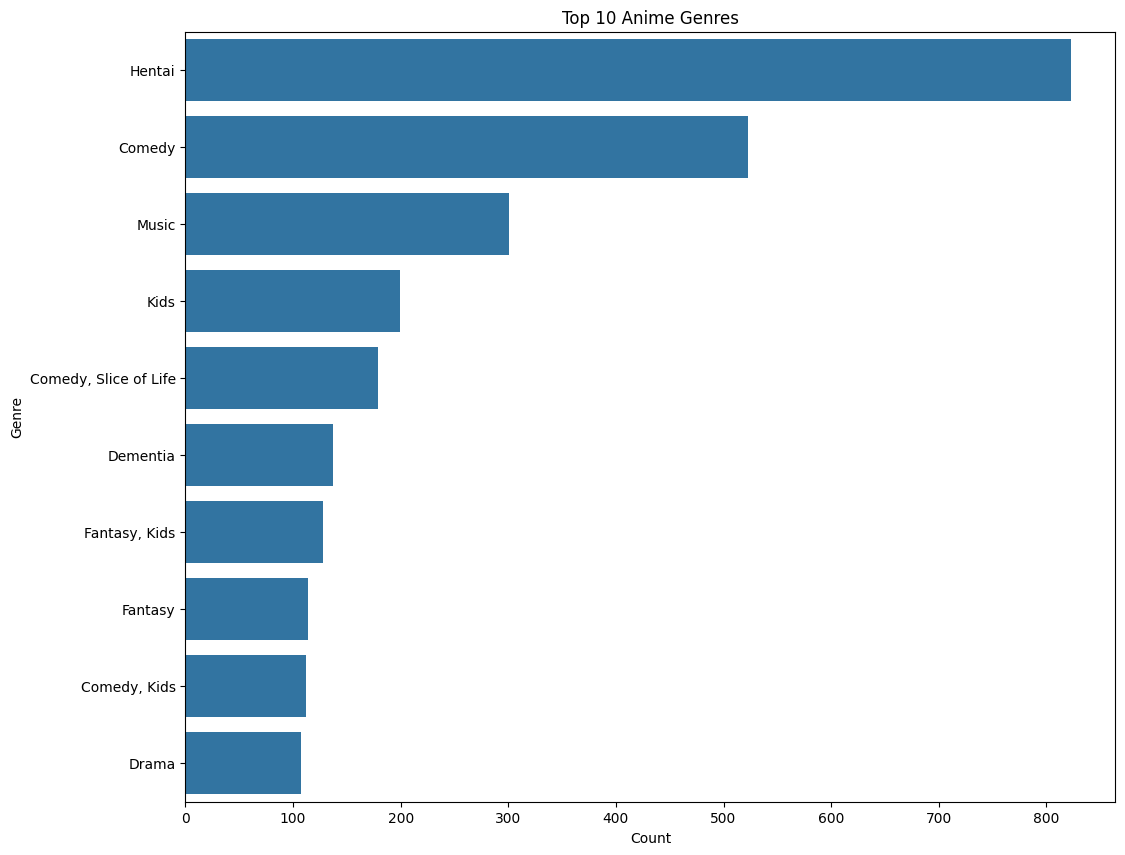

In [16]:
# The highest rating animes
anime_data.show(10)

# The most rated animes
most_rated_animes = rating_data.groupBy("anime_id").agg(count("rating").alias("num_ratings"))

final_df = most_rated_animes.join(anime_data, 'anime_id').select('name', 'num_ratings')
distinct_df = final_df.dropDuplicates()
distinct_df.orderBy(desc('num_ratings')).show(10)


# Most popular genres
genre_popularity = anime_data.groupBy('genre').agg(count('anime_id').alias('count'))
genre_popularity.orderBy(desc('count')).show()

# Collecting the data from the PySpark DataFrame
collected_data = genre_popularity.orderBy('count', ascending=False).collect()

# Extracting genres and counts into separate lists
genres = [row['genre'] for row in collected_data]
counts = [row['count'] for row in collected_data]

# Select the top N genres for plotting
top_n = 10
genres = genres[:top_n]
counts = counts[:top_n]

# Create a horizontal bar plot with the top N genres
plt.figure(figsize=(12, 10))  # Adjust the size as needed for readability
sns.barplot(x=counts, y=genres)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Anime Genres')
plt.show()

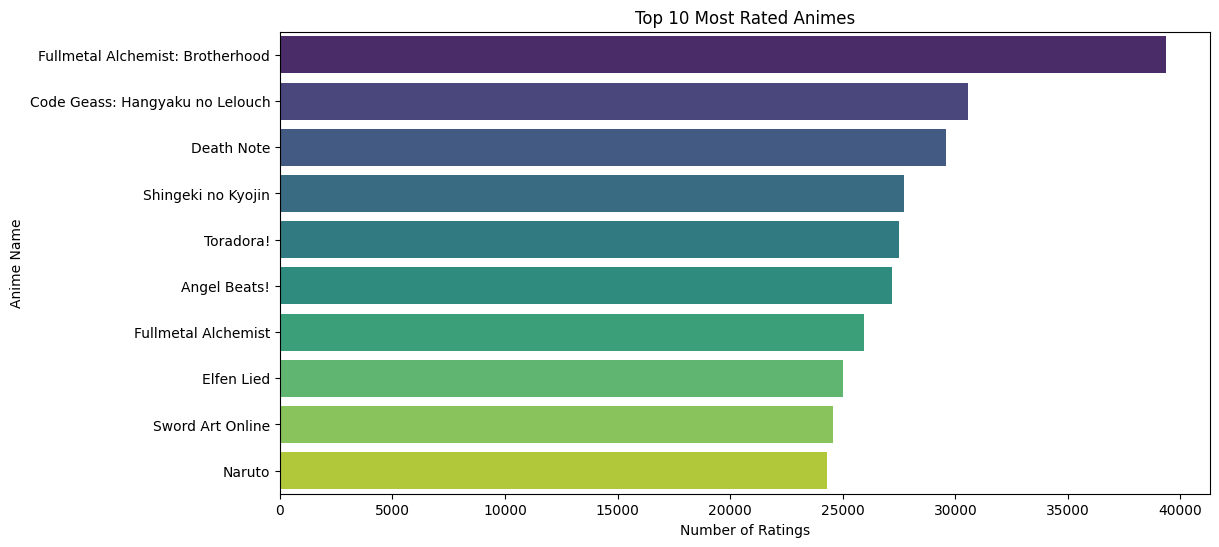

In [23]:
# Converting to pandas for visualization
anime_pd = anime_data.toPandas()
rating_pd = rating_data.toPandas()

# Barchart for most rated animes
most_rated_animes = rating_pd['anime_id'].value_counts().head(10)
most_rated_anime_names = anime_pd.loc[anime_pd['anime_id'].isin(most_rated_animes.index), 'name']

plt.figure(figsize=(12, 6))
sns.barplot(y=most_rated_anime_names, x=most_rated_animes.values, hue=most_rated_anime_names, palette='viridis', dodge=False)
plt.title('Top 10 Most Rated Animes')
plt.xlabel('Number of Ratings')
plt.ylabel('Anime Name')
plt.show()

In [5]:
anime_data.printSchema()

root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- members: integer (nullable = true)



In [6]:
rating_data.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [7]:
# Check for NaN values in the 'rating' column
nan_rows = rating_data.filter(isnan(col("rating")))

# Count the number of rows with NaN values in the 'rating' column
nan_count = nan_rows.count()

if nan_count > 0:
    print(f"There are {nan_count} rows with NaN values in the 'rating' column.")
else:
    print("There are no NaN values in the 'rating' column.")

There are no NaN values in the 'rating' column.


In [12]:
# Check for null values in the 'rating' column
null_rows = rating_data.filter(col("rating",).isNull())

# Count the number of rows with null values in the 'rating' column
null_count = null_rows.count()

if null_count > 0:
    print(f"There are {null_count} rows with null values in the 'rating' column.")
else:
    print("There are no null values in the 'rating' column.")

There are no null values in the 'rating' column.


In [7]:
# Here we dropped the value "-1" from the dataset. They were created because of the users that did not vote.
filtered_data = rating_data.filter(rating_data.rating != -1)

In [ ]:
filtered_data.show(50)

In [6]:
# We can see it in a .csv file as well
filtered_data.write.csv('dataset/filtered_data.csv', header=True)

In [8]:
# Creating our train and test data from rating_data. ALS needs all values to be numeric so do not need to change anything. 
# Setting the seed based on our student numbers.
train_data, test_data = filtered_data.randomSplit([0.7, 0.3], seed = 5072)

In [9]:
# Setting checkpoints to avoid StackOverflowError which caused by not having enough RAM
sc.setCheckpointDir('C:/spark/checkpoint')

In [ ]:
# These are the variables for ALS model so we can monitize and configure the training process. 
# We explained every variable for better grasp of the concepts
# Iteration is the amount of the how many times does the ALS Algortihm going to perform. The higher amount resulst as better accuracy but higher computational time.
# For example iterations = 10
# Regularization is a technique used to prevent overfitting in machine learning models 
# For example regularizationParameter = 0.1
# This parameter determines the number of latent factors.
# For example rank = 10

In [10]:
# Here we defining our prediction function so we can create models one by one. This way it is easier.
def prediction(rank, maxIter, regParam):
    als = ALS(userCol='user_id', itemCol='anime_id', ratingCol='rating', seed=5072, implicitPrefs=False, nonnegative=True, coldStartStrategy='drop', rank=rank, maxIter=maxIter, regParam=regParam)
    model = als.fit(train_data)

    # Checkpoint the model factors to truncate lineage
    model.userFactors.checkpoint()
    model.itemFactors.checkpoint()

    # Creating predictions on the test data
    predictions = model.transform(test_data)
    predictions = predictions.withColumnRenamed('prediction', 'Prediction')

    # Evaluating error values here.
    rmse_evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='Prediction')
    rmse = rmse_evaluator.evaluate(predictions)
    
    mse_evaluator = RegressionEvaluator(metricName='mse', labelCol='rating', predictionCol='Prediction')
    mse = mse_evaluator.evaluate(predictions)

    return {'model': model, 'predictions': predictions, 'error_results': {'rank': rank, 'iteration': maxIter, 'lambda': regParam, 'RMSE': rmse, 'MSE': mse}}

In [11]:
def add_model_results(result_dict, model_name, error_results):
    result_dict[model_name] = {'RMSE': error_results['RMSE'], 'MSE': error_results['MSE']}

result_dict = {}

In [ ]:
# From now on we will create 18 models with different rank, iteration and regression values.
# We will assign our values to the "prediction" function we creaeted.

In [12]:
model_1_1 = prediction(10, 10, 0.01)
print(model_1_1['error_results'])
print()
model_1_1['predictions'].show(50, truncate=True)

{'rank': 10, 'iteration': 10, 'lambda': 0.01, 'RMSE': 1.180767888836024, 'MSE': 1.3942128073062425}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6| 7.2277327|
|   4101|    1829|     4|  4.250895|
|   4519|    8086|     9|  8.303693|
|   5300|    1238|    10|  9.867873|
|   7340|    5300|     7|  8.235204|
|  18944|    4935|     8|  8.231689|
|  19530|     463|     8| 6.7583046|
|  19530|   17389|     9|  9.535899|
|  19530|   30654|    10|    8.9105|
|    392|    8086|     9|     6.372|
|    392|   22097|     8|  6.103707|
|   1522|   25517|     7|  7.537274|
|   4161|    8086|     9| 7.8572607|
|   6773|    1829|    10| 7.9669113|
|   7168|    1829|     6|   7.23841|
|   7168|    8086|     8|  8.309407|
|  14075|   30654|     8|  9.251671|
|  17172|    8086|     8|  8.503414|
|  18467|    8086|     7| 7.3570504|
|  19758|    9465|     8| 7.8243837|
|  20596|    5300|     8| 7.9460993|
|  22004|  

In [46]:
model_name = 'model_1_1'
error_results = model_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
#model_path = f"./saved_models/{model_name}_model"
#model_1_1['model'].save(model_path)

In [43]:
model_1_2 = prediction(10, 50, 0.01)
print(model_1_2['error_results'])
print()
model_1_2['predictions'].show(50, truncate = True)

{'rank': 10, 'iteration': 50, 'lambda': 0.01, 'RMSE': 1.1736307273035922, 'MSE': 1.3774090840711588}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|      81|     8| 7.6280317|
|    148|     263|     9|  9.070044|
|    148|     265|     7|    8.4229|
|    148|     356|     6| 6.0201273|
|    148|     481|    10| 7.7517567|
|    148|     627|     8|  8.262184|
|    148|     857|     6| 6.6652126|
|    148|     859|     9|  6.397938|
|    148|    1313|     8| 7.3793974|
|    148|    1575|     8|  8.345653|
|    148|    1604|     8|  7.873198|
|    148|    2961|     8|   7.96082|
|    148|    3972|     8|   7.77951|
|    148|    4155|     8|  8.411564|
|    148|    6702|     7| 7.6665373|
|    148|    6951|     7| 7.8556724|
|    148|    7593|     4| 5.1258264|
|    148|    7674|     9|  8.293822|
|    148|    7817|     8| 5.3939962|
|    148|    8086|     6|  6.707505|
|    148|    8457|     6|  7.159229|
|    148| 

In [47]:
model_name = 'model_1_2'
error_results = model_1_2['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
#model_path = f"./saved_models/{model_name}_model"
#model_1_2['model'].save(model_path)

In [45]:
model_1_3 = prediction(10, 200, 0.01)
print(model_1_3['error_results'])
print()
model_1_3['predictions'].show(50, truncate = True)

{'rank': 10, 'iteration': 200, 'lambda': 0.01, 'RMSE': 1.1664766860882234, 'MSE': 1.3606678591873635}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  6.622569|
|   4101|    1829|     4|   5.06654|
|   4519|    8086|     9|  8.744582|
|   5300|    1238|    10| 10.088274|
|   7340|    5300|     7| 7.9940214|
|  18944|    4935|     8|  8.467243|
|  19530|     463|     8|  7.003373|
|  19530|   17389|     9|  9.133966|
|  19530|   30654|    10|   9.02304|
|    392|    8086|     9| 6.6375628|
|    392|   22097|     8| 6.3090463|
|   1522|   25517|     7| 7.6307445|
|   4161|    8086|     9| 7.7322507|
|   6773|    1829|    10|  8.054954|
|   7168|    1829|     6|  8.262102|
|   7168|    8086|     8| 8.7209635|
|  14075|   30654|     8|  8.780756|
|  17172|    8086|     8|  8.472819|
|  18467|    8086|     7|  7.075102|
|  19758|    9465|     8| 7.6392093|
|  20596|    5300|     8|  8.697666|
|  22004|

In [48]:
model_name = 'model_1_3'

error_results = model_1_3['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
#model_path = f"./saved_models/{model_name}_model"
#model_1_3['model'].save(model_path)

In [50]:
model_2_1 = prediction(50, 10, 0.01)
print(model_2_1['error_results'])
print()
model_2_1['predictions'].show(50, truncate = True)

{'rank': 50, 'iteration': 10, 'lambda': 0.01, 'RMSE': 1.2648116405479533, 'MSE': 1.5997484860656048}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  7.198944|
|    385|   30654|    10|  9.485469|
|    392|    8086|     9| 6.3923693|
|    392|   22097|     8|  5.943227|
|    435|    6336|     9|    9.2582|
|    436|    1829|     8| 8.2978325|
|    460|    8086|     8|  7.392449|
|    497|    3918|     7|  8.539971|
|    497|    9465|     8| 7.6493306|
|    559|    5300|     9|  9.140572|
|    660|    1088|     8| 8.2715845|
|    744|    1829|     7| 6.3592644|
|    774|   25517|     8|  9.383099|
|    852|    9465|     7| 7.2731066|
|    857|    1238|     9|  7.930838|
|   1005|    1088|     8| 7.6562405|
|   1019|    9465|     9|  8.342998|
|   1019|   22097|     7| 7.8910418|
|   1019|   30654|     9|  8.739083|
|   1031|   30654|     9|  8.249429|
|   1051|    1829|     5| 5.7875834|
|   1130| 

In [51]:
model_name = 'model_2_1'
error_results = model_2_1['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
#model_path = f"./saved_models/{model_name}_model"
#model_2_1['model'].save(model_path)

In [12]:
model_2_2 = prediction(50, 50, 0.01)
print(model_2_2['error_results'])
print()
model_2_2['predictions'].show(50, truncate = True)

{'rank': 50, 'iteration': 50, 'lambda': 0.01, 'RMSE': 1.2849475180752332, 'MSE': 1.6510901242077018}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  6.771369|
|    385|   30654|    10|  9.304529|
|    392|    8086|     9|  7.203097|
|    392|   22097|     8| 5.3710546|
|    435|    6336|     9|  9.018963|
|    436|    1829|     8|  8.501857|
|    460|    8086|     8| 7.8108215|
|    497|    3918|     7|  8.004473|
|    497|    9465|     8|  8.046586|
|    559|    5300|     9|  8.648371|
|    660|    1088|     8|  6.826586|
|    744|    1829|     7| 6.0459437|
|    774|   25517|     8| 6.7439795|
|    852|    9465|     7| 7.3576775|
|    857|    1238|     9|  8.425419|
|   1005|    1088|     8|  5.998312|
|   1019|    9465|     9| 7.9493423|
|   1019|   22097|     7|  8.391909|
|   1019|   30654|     9|  8.930856|
|   1031|   30654|     9|  9.063549|
|   1051|    1829|     5|  5.404509|
|   1130| 

In [13]:
model_name = 'model_2_2'
error_results = model_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_2_2['model'].save(model_path)

In [14]:
model_2_3 = prediction(50, 200, 0.01)
print(model_2_3['error_results'])
print()
model_2_3['predictions'].show(50, truncate = True)

{'rank': 50, 'iteration': 200, 'lambda': 0.01, 'RMSE': 1.2866443635617824, 'MSE': 1.6554537182853037}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6| 6.4202104|
|    385|   30654|    10|  9.376431|
|    392|    8086|     9|  7.397426|
|    392|   22097|     8|  6.409424|
|    435|    6336|     9|  8.918802|
|    436|    1829|     8|  8.845422|
|    460|    8086|     8|   8.27612|
|    497|    3918|     7|  5.942352|
|    497|    9465|     8|  8.180781|
|    559|    5300|     9|  8.611361|
|    660|    1088|     8|  7.592229|
|    744|    1829|     7| 5.9175735|
|    774|   25517|     8| 6.3550105|
|    852|    9465|     7| 7.5219293|
|    857|    1238|     9|  7.912756|
|   1005|    1088|     8| 6.2203693|
|   1019|    9465|     9|  8.065406|
|   1019|   22097|     7|   8.26922|
|   1019|   30654|     9|  8.708409|
|   1031|   30654|     9|  8.981707|
|   1051|    1829|     5| 6.0749207|
|   1130|

In [15]:
model_name = 'model_2_3'
error_results = model_2_3['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_2_3['model'].save(model_path)

In [16]:
model_3_1 = prediction(200, 10, 0.01)
print(model_3_1['error_results'])
print()
model_3_1['predictions'].show(50, truncate = True)

{'rank': 200, 'iteration': 10, 'lambda': 0.01, 'RMSE': 1.2602025935709023, 'MSE': 1.5881105768428287}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|    7.2719|
|    385|   30654|    10| 9.4407215|
|    392|    8086|     9| 7.9163513|
|    392|   22097|     8|   6.23695|
|    435|    6336|     9|  9.617956|
|    436|    1829|     8|  9.803596|
|    460|    8086|     8|   8.44171|
|    497|    3918|     7| 7.6352453|
|    497|    9465|     8|  7.835855|
|    559|    5300|     9|  8.017685|
|    660|    1088|     8|   9.72684|
|    744|    1829|     7| 6.9965425|
|    774|   25517|     8|   7.00314|
|    852|    9465|     7| 7.0932755|
|    857|    1238|     9|  8.422761|
|   1005|    1088|     8|  7.493257|
|   1019|    9465|     9|  8.344841|
|   1019|   22097|     7|  8.601428|
|   1019|   30654|     9|  8.755978|
|   1031|   30654|     9|  8.697283|
|   1051|    1829|     5|  7.226719|
|   1130|

In [17]:
model_name = 'model_3_1'
error_results = model_3_1['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_3_1['model'].save(model_path)

In [18]:
model_3_2 = prediction(200, 50, 0.01)
print(model_3_2['error_results'])
print()
model_3_2['predictions'].show(50, truncate = True)

{'rank': 200, 'iteration': 50, 'lambda': 0.01, 'RMSE': 1.2577173057268038, 'MSE': 1.5818528211246907}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  6.722072|
|    385|   30654|    10|   9.94764|
|    392|    8086|     9|  6.466609|
|    392|   22097|     8| 6.2155366|
|    435|    6336|     9|    8.6481|
|    436|    1829|     8|  9.453625|
|    460|    8086|     8|   8.10779|
|    497|    3918|     7| 6.8134904|
|    497|    9465|     8|  7.513176|
|    559|    5300|     9| 8.3577385|
|    660|    1088|     8|  8.285272|
|    744|    1829|     7|  6.854541|
|    774|   25517|     8|  8.476585|
|    852|    9465|     7| 7.1577516|
|    857|    1238|     9|  8.283467|
|   1005|    1088|     8| 6.7436337|
|   1019|    9465|     9|  8.534082|
|   1019|   22097|     7|  8.359372|
|   1019|   30654|     9|  8.748128|
|   1031|   30654|     9|  9.500013|
|   1051|    1829|     5| 6.6049795|
|   1130|

In [19]:
model_name = 'model_3_2'
error_results = model_3_2['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_3_2['model'].save(model_path)

In [20]:
model_3_3 = prediction(200, 200, 0.01)
print(model_3_3['error_results'])
print()
model_3_3['predictions'].show(50, truncate = True)

{'rank': 200, 'iteration': 200, 'lambda': 0.01, 'RMSE': 1.2679550928443994, 'MSE': 1.6077101174700497}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6| 6.9547157|
|    385|   30654|    10|  9.231932|
|    392|    8086|     9| 6.0995345|
|    392|   22097|     8| 6.9767575|
|    435|    6336|     9|  9.427564|
|    436|    1829|     8|  9.315479|
|    460|    8086|     8| 7.9400187|
|    497|    3918|     7| 6.0911975|
|    497|    9465|     8| 7.0014563|
|    559|    5300|     9|  8.607194|
|    660|    1088|     8|  7.630757|
|    744|    1829|     7| 6.1353726|
|    774|   25517|     8|  8.270777|
|    852|    9465|     7| 6.9659915|
|    857|    1238|     9|  8.247106|
|   1005|    1088|     8| 7.4222164|
|   1019|    9465|     9|  8.837047|
|   1019|   22097|     7|   8.57108|
|   1019|   30654|     9|  8.768641|
|   1031|   30654|     9|   9.40885|
|   1051|    1829|     5| 7.1967587|
|   1130

In [21]:
model_name = 'model_3_3'
error_results = model_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_3_3['model'].save(model_path)

In [22]:
model_1_1_1 = prediction(10, 10, 0.1)
print(model_1_1_1['error_results'])
print()
model_1_1_1['predictions'].show(50, truncate = True)

{'rank': 10, 'iteration': 10, 'lambda': 0.1, 'RMSE': 1.171975391829191, 'MSE': 1.373526319053186}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|      81|     8|  7.540984|
|    148|     263|     9|   8.47855|
|    148|     265|     7|  7.853799|
|    148|     356|     6|  6.621006|
|    148|     481|    10| 7.1668835|
|    148|     627|     8| 7.9083295|
|    148|     857|     6| 6.8513403|
|    148|     859|     9| 6.4423146|
|    148|    1313|     8|  6.813751|
|    148|    1575|     8|  8.320822|
|    148|    1604|     8| 7.7753696|
|    148|    2961|     8|  7.080803|
|    148|    3972|     8| 7.1332917|
|    148|    4155|     8|  8.075708|
|    148|    6702|     7| 7.4594865|
|    148|    6951|     7|  6.917511|
|    148|    7593|     4|  5.317878|
|    148|    7674|     9|  7.920257|
|    148|    7817|     8| 5.9565334|
|    148|    8086|     6|   7.05981|
|    148|    8457|     6| 6.9683504|
|    148|    

In [23]:
model_name = 'model_1_1_1'
error_results = model_1_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_1_1_1['model'].save(model_path)

In [24]:
model_1_2_2 = prediction(10, 50, 0.1)
print(model_1_2_2['error_results'])
print()
model_1_2_2['predictions'].show(50, truncate = True)

{'rank': 10, 'iteration': 50, 'lambda': 0.1, 'RMSE': 1.1317968191907684, 'MSE': 1.280964039930341}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|      81|     8|  7.567369|
|    148|     263|     9| 8.6684475|
|    148|     265|     7|  7.979082|
|    148|     356|     6|   6.73332|
|    148|     481|    10|  7.277576|
|    148|     627|     8|  8.075799|
|    148|     857|     6| 6.8068504|
|    148|     859|     9| 6.4480133|
|    148|    1313|     8| 6.8982663|
|    148|    1575|     8|  8.423849|
|    148|    1604|     8| 7.9162393|
|    148|    2961|     8|  7.211518|
|    148|    3972|     8|  7.132146|
|    148|    4155|     8|  8.185219|
|    148|    6702|     7|  7.770814|
|    148|    6951|     7|  6.950466|
|    148|    7593|     4|  5.788877|
|    148|    7674|     9|  8.059187|
|    148|    7817|     8| 6.3083787|
|    148|    8086|     6| 6.9433565|
|    148|    8457|     6| 7.0455093|
|    148|   

In [25]:
model_name = 'model_1_2_2'
error_results = model_1_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_1_2_2['model'].save(model_path)

In [26]:
model_1_3_3 = prediction(10, 200, 0.1)
print(model_1_3_3['error_results'])
print()
model_1_3_3['predictions'].show(50, truncate = True)

{'rank': 10, 'iteration': 200, 'lambda': 0.1, 'RMSE': 1.1289527515685227, 'MSE': 1.2745343152741386}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  6.926481|
|   4101|    1829|     4|  4.842019|
|   4519|    8086|     9|   8.70403|
|   5300|    1238|    10|  9.852707|
|   7340|    5300|     7|  8.021009|
|  18944|    4935|     8|  8.365137|
|  19530|     463|     8| 6.6747665|
|  19530|   17389|     9|  9.093697|
|  19530|   30654|    10|  8.676842|
|    392|    8086|     9| 6.3139853|
|    392|   22097|     8|  6.313149|
|   1522|   25517|     7|  7.620284|
|   4161|    8086|     9|  7.635723|
|   6773|    1829|    10|  7.723912|
|   7168|    1829|     6| 7.9538913|
|   7168|    8086|     8|   8.16601|
|  14075|   30654|     8|  8.725676|
|  17172|    8086|     8| 8.3710985|
|  18467|    8086|     7|  7.170026|
|  19758|    9465|     8|  7.525538|
|  20596|    5300|     8|  8.046064|
|  22004| 

In [27]:
model_name = 'model_1_3_3'
error_results = model_1_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_1_3_3['model'].save(model_path)

In [28]:
model_2_1_1 = prediction(50, 10, 0.1)
print(model_2_1_1['error_results'])
print()
model_2_1_1['predictions'].show(50, truncate = True)

{'rank': 50, 'iteration': 10, 'lambda': 0.1, 'RMSE': 1.1522227742882678, 'MSE': 1.3276173215885523}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6| 6.8409395|
|    385|   30654|    10|   9.16059|
|    392|    8086|     9|  6.393499|
|    392|   22097|     8| 6.1660256|
|    435|    6336|     9|  8.928679|
|    436|    1829|     8| 7.6318455|
|    460|    8086|     8| 7.5006723|
|    497|    3918|     7|   7.80402|
|    497|    9465|     8| 7.0447135|
|    559|    5300|     9| 7.9989295|
|    660|    1088|     8| 7.5431643|
|    744|    1829|     7|  6.682208|
|    774|   25517|     8| 6.9270043|
|    852|    9465|     7|  7.376906|
|    857|    1238|     9|  7.538529|
|   1005|    1088|     8|  7.001335|
|   1019|    9465|     9| 7.8427353|
|   1019|   22097|     7| 7.8458977|
|   1019|   30654|     9|  8.348861|
|   1031|   30654|     9|  8.296665|
|   1051|    1829|     5| 6.4566216|
|   1130|  

In [29]:
model_name = 'model_2_1_1'
error_results = model_2_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_2_1_1['model'].save(model_path)

In [30]:
model_2_2_2 = prediction(50, 50, 0.1)
print(model_2_2_2['error_results'])
print()
model_2_2_2['predictions'].show(50, truncate = True)

{'rank': 50, 'iteration': 50, 'lambda': 0.1, 'RMSE': 1.1165229030593746, 'MSE': 1.246623393056134}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6| 6.8880033|
|    385|   30654|    10|  9.290871|
|    392|    8086|     9| 6.6177993|
|    392|   22097|     8|  6.292266|
|    435|    6336|     9| 9.0066185|
|    436|    1829|     8|  8.059556|
|    460|    8086|     8| 7.7062097|
|    497|    3918|     7|   7.88398|
|    497|    9465|     8|  7.361595|
|    559|    5300|     9|  8.297088|
|    660|    1088|     8|  7.827271|
|    744|    1829|     7|  6.804135|
|    774|   25517|     8|  7.093532|
|    852|    9465|     7|  7.497753|
|    857|    1238|     9| 7.7027593|
|   1005|    1088|     8|  7.205782|
|   1019|    9465|     9|  8.080592|
|   1019|   22097|     7|  7.987131|
|   1019|   30654|     9|  8.477903|
|   1031|   30654|     9|  8.429088|
|   1051|    1829|     5| 6.5792184|
|   1130|   

In [31]:
model_name = 'model_2_2_2'
error_results = model_2_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_2_2_2['model'].save(model_path)

In [32]:
model_2_3_3 = prediction(50, 200, 0.1)
print(model_2_3_3['error_results'])
print()
model_2_3_3['predictions'].show(50, truncate = True)

{'rank': 50, 'iteration': 200, 'lambda': 0.1, 'RMSE': 1.1145680450021174, 'MSE': 1.2422619269398418}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6| 6.9510994|
|    385|   30654|    10|  9.297622|
|    392|    8086|     9|  6.636566|
|    392|   22097|     8|  6.313622|
|    435|    6336|     9|  8.996674|
|    436|    1829|     8|  8.007469|
|    460|    8086|     8| 7.6759357|
|    497|    3918|     7| 7.7268558|
|    497|    9465|     8| 7.4409122|
|    559|    5300|     9|  8.256085|
|    660|    1088|     8| 7.8251214|
|    744|    1829|     7| 6.6754975|
|    774|   25517|     8| 7.0106664|
|    852|    9465|     7|  7.527699|
|    857|    1238|     9|  7.798628|
|   1005|    1088|     8|  7.143769|
|   1019|    9465|     9| 8.0810375|
|   1019|   22097|     7|  8.004279|
|   1019|   30654|     9|  8.495624|
|   1031|   30654|     9|  8.531604|
|   1051|    1829|     5| 6.7074647|
|   1130| 

In [33]:
model_name = 'model_2_3_3'
error_results = model_2_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_2_3_3['model'].save(model_path)

In [34]:
model_3_1_1 = prediction(200, 10, 0.1)
print(model_3_1_1['error_results'])
print()
model_3_1_1['predictions'].show(50, truncate = True)

{'rank': 200, 'iteration': 10, 'lambda': 0.1, 'RMSE': 1.1374898917079934, 'MSE': 1.2938832537378626}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  6.903206|
|    385|   30654|    10|  9.178614|
|    392|    8086|     9| 6.3129005|
|    392|   22097|     8|  6.223024|
|    435|    6336|     9|   8.89636|
|    436|    1829|     8| 7.8814526|
|    460|    8086|     8| 7.5365114|
|    497|    3918|     7|   8.02029|
|    497|    9465|     8|  7.191559|
|    559|    5300|     9|  8.121253|
|    660|    1088|     8| 7.5075803|
|    744|    1829|     7|  6.593842|
|    774|   25517|     8| 6.8824944|
|    852|    9465|     7|  7.388301|
|    857|    1238|     9|  7.511454|
|   1005|    1088|     8|  7.107518|
|   1019|    9465|     9| 7.9100337|
|   1019|   22097|     7|  7.908649|
|   1019|   30654|     9|   8.40472|
|   1031|   30654|     9|  8.381318|
|   1051|    1829|     5| 6.5945497|
|   1130| 

In [35]:
model_name = 'model_3_1_1'
error_results = model_3_1_1['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_3_1_1['model'].save(model_path)

In [36]:
model_3_2_2 = prediction(200, 50, 0.1)
print(model_3_2_2['error_results'])
print()
model_3_2_2['predictions'].show(50, truncate = True)

{'rank': 200, 'iteration': 50, 'lambda': 0.1, 'RMSE': 1.1124962329701966, 'MSE': 1.2376478683728782}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  7.001505|
|    385|   30654|    10|  9.319105|
|    392|    8086|     9| 6.4370084|
|    392|   22097|     8|  6.364867|
|    435|    6336|     9|  9.018495|
|    436|    1829|     8|  7.814633|
|    460|    8086|     8|  7.661405|
|    497|    3918|     7| 7.4611316|
|    497|    9465|     8| 7.4463787|
|    559|    5300|     9|  8.312435|
|    660|    1088|     8|  7.807183|
|    744|    1829|     7|  6.506602|
|    774|   25517|     8| 6.9416647|
|    852|    9465|     7| 7.4349017|
|    857|    1238|     9| 7.6845965|
|   1005|    1088|     8|  7.380583|
|   1019|    9465|     9|  8.063202|
|   1019|   22097|     7| 7.9714565|
|   1019|   30654|     9| 8.4789095|
|   1031|   30654|     9|  8.489926|
|   1051|    1829|     5|  6.665232|
|   1130| 

In [37]:
model_name = 'model_3_2_2'
error_results = model_3_2_2['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_3_2_2['model'].save(model_path)

In [38]:
model_3_3_3 = prediction(200, 200, 0.1)
print(model_3_3_3['error_results'])
print()
model_3_3_3['predictions'].show(50, truncate = True)

{'rank': 200, 'iteration': 200, 'lambda': 0.1, 'RMSE': 1.110333735061979, 'MSE': 1.2328410032166852}

+-------+--------+------+----------+
|user_id|anime_id|rating|Prediction|
+-------+--------+------+----------+
|    148|    8086|     6|  7.010955|
|    385|   30654|    10|  9.349146|
|    392|    8086|     9|  6.455826|
|    392|   22097|     8|  6.332483|
|    435|    6336|     9|  9.024903|
|    436|    1829|     8| 7.8359165|
|    460|    8086|     8| 7.6703386|
|    497|    3918|     7| 7.4112024|
|    497|    9465|     8| 7.5077386|
|    559|    5300|     9|  8.305336|
|    660|    1088|     8| 7.8894863|
|    744|    1829|     7|  6.520421|
|    774|   25517|     8|  6.976941|
|    852|    9465|     7|  7.423413|
|    857|    1238|     9| 7.6488013|
|   1005|    1088|     8|  7.323841|
|   1019|    9465|     9|  8.100235|
|   1019|   22097|     7|   7.99091|
|   1019|   30654|     9|  8.479448|
|   1031|   30654|     9|  8.506236|
|   1051|    1829|     5|  6.748445|
|   1130| 

In [39]:
model_name = 'model_3_3_3'
error_results = model_3_3_3['error_results']
add_model_results(result_dict, model_name, error_results)

# Save the trained model
model_path = f"./saved_models/{model_name}_model"
model_3_3_3['model'].save(model_path)

In [69]:
# Collecting all the error results together so we can choose the best one.
error_results = []

error_results.append(model_1_1['error_results'])
error_results.append(model_1_2['error_results'])
error_results.append(model_1_3['error_results'])
error_results.append(model_2_1['error_results'])
error_results.append(model_2_2['error_results'])
error_results.append(model_2_3['error_results'])
error_results.append(model_3_1['error_results'])
error_results.append(model_3_2['error_results'])
error_results.append(model_3_3['error_results'])

error_results.append(model_1_1_1['error_results'])
error_results.append(model_1_2_2['error_results'])
error_results.append(model_1_3_3['error_results'])
error_results.append(model_2_1_1['error_results'])
error_results.append(model_2_2_2['error_results'])
error_results.append(model_2_3_3['error_results'])
error_results.append(model_3_1_1['error_results'])
error_results.append(model_3_2_2['error_results'])
error_results.append(model_3_3_3['error_results'])

error_results_data_frame = spark.createDataFrame(error_results)
error_results_data_frame.show(50, truncate = True)

+------------------+------------------+---------+------+----+
|               MSE|              RMSE|iteration|lambda|rank|
+------------------+------------------+---------+------+----+
|1.3942128073062814|1.1807678888360076|       10|  0.01|  10|
|1.3774090840711588|1.1736307273035922|       50|  0.01|  10|
|1.3606678591873635|1.1664766860882234|      200|  0.01|  10|
|1.5997484860656048|1.2648116405479533|       10|  0.01|  50|
|1.6510901242077018|1.2849475180752332|       50|  0.01|  50|
|1.6554537182853037|1.2866443635617824|      200|  0.01|  50|
|1.5881105768428287|1.2602025935709023|       10|  0.01| 200|
|1.5818528211246907|1.2577173057268038|       50|  0.01| 200|
|1.6077101174700497|1.2679550928443994|      200|  0.01| 200|
| 1.373526319053186| 1.171975391829191|       10|   0.1|  10|
| 1.280964039930341|1.1317968191907684|       50|   0.1|  10|
|1.2745343152741386|1.1289527515685227|      200|   0.1|  10|
|1.3276173215885523|1.1522227742882678|       10|   0.1|  50|
| 1.2466

In [68]:
model_listesi = ['model_1_1', 'model_1_2', 'model_1_3', 'model_2_1', 'model_2_2', 'model_2_3', 'model_3_1', 'model_3_2', 'model_3_3', 'model_1_1_1', 'model_1_2_2', 'model_1_3_3', 'model_2_1_1', 'model_2_2_2', 'model_2_3_3', 'model_3_1_1', 'model_3_2_2', 'model_3_3_3']

best_rmse = float('inf')
best_mse = float('inf')
best_result_index = None

# Here we select the best model from all of the 18 of them.
for i, model in enumerate(model_listesi):
    result = result_dict[model]
    rmse = result['RMSE']
    mse = result['MSE']

    if rmse <= best_rmse and mse <= best_mse:
        best_rmse = rmse
        best_mse = mse
        best_result_index = i

best_model = model_listesi[best_result_index]

print('Best model based on RMSE and MSE:', result_dict[best_model])
print(f'Best model is: {best_model}', "\n")
print("The best model is selected based on having the lowest RMSE or MSE values, as these indicate the model's ability to minimize prediction errors. Lower values suggest that the model's predictions are closer to the actual values, resulting in better performance.")

Best model based on RMSE and MSE: {'RMSE': 1.110333735061979, 'MSE': 1.2328410032166852}
Best model is: model_3_3_3 

The best model is selected based on having the lowest RMSE or MSE values, as these indicate the model's ability to minimize prediction errors. Lower values suggest that the model's predictions are closer to the actual values, resulting in better performance.


In [54]:
if best_model in globals():
    my_dict = globals()[best_model]

In [ ]:
# Here we can reload the best model which is "model_3_3_3" if we need to close the notebook.
from pyspark.ml import PipelineModel

best_model = PipelineModel.load("C:/spark/saved_models/model_3_3_3_model")

In [70]:
best_model_item_factors = my_dict['model'].itemFactors

# Selecting a anime by its id
anime_id = 5114
other_anime = []

# Here we are selecting features of the selected anime
selected_anime = best_model_item_factors.where(best_model_item_factors.id == anime_id).select('features')

selected_anime_features = selected_anime.rdd.map(lambda x: x.features).first()

# Creating similarity scores
for row in best_model_item_factors.rdd.toLocalIterator():
    if row.id != anime_id:
        v1 = np.asarray(row.features)
        v2 = np.asarray(selected_anime_features)
        similarity_score = v1.dot(v2) / (LA.norm(v1) * LA.norm(v2))
        other_anime.append([row.id, similarity_score])
R = Row('anime_id', 'Similarity_Score')

similar_items_dataframe = spark.createDataFrame([R(column[0], float(column[1])) for column in other_anime])

similarity_sum_rdd = similar_items_dataframe.rdd.map(lambda x: (x['anime_id'], x['Similarity_Score'])).reduceByKey(lambda a, b: a + b)

R = Row('anime_id', 'Similarity_Sum')
similarity_sum_dataframe = spark.createDataFrame([R(anime_id, similarity_sum) for anime_id, similarity_sum in similarity_sum_rdd.collect()])

In [71]:
# Select the top 10 movies by similarity sum
top_ten_animes = similarity_sum_dataframe.orderBy(similarity_sum_dataframe.Similarity_Sum.desc()).limit(10)
# Show the top 10 movies
top_ten_animes.show()

+--------+------------------+
|anime_id|    Similarity_Sum|
+--------+------------------+
|   11061|0.9719663865180806|
|   32935|0.9717758209140763|
|   28891|0.9679518459098359|
|   32281|0.9632767718097761|
|    9253|0.9612883804736423|
|   32182|0.9610627655232898|
|   19647|0.9569344438081177|
|   20583|0.9557813683305668|
|   10162| 0.955177073458411|
|   28977|0.9549457703971804|
+--------+------------------+



In [72]:
# Returns list
top_ten_anime_ids = top_ten_animes.rdd.map(lambda x: x.anime_id).collect()

In [73]:
# Filtering the users who rated for the selected id "5114"
users_who_rated_selected_anime = my_dict['predictions'].filter(my_dict['predictions'].anime_id == anime_id)
# Getting the id's of the users who rated the selected anime
user_ids_who_rated_selected_anime = users_who_rated_selected_anime.select("user_id").rdd.flatMap(lambda x: x).collect()
# Also filtering the ones that did not rated the selected anime
users_without_rated_selected_anime = my_dict['predictions'].filter(~my_dict['predictions'].user_id.isin(user_ids_who_rated_selected_anime))

In [74]:
recommended_users = []
for new_anime_id in top_ten_anime_ids:
    # Filtering id's from the predictions
    recommended_selected_anime = my_dict['predictions'].filter(my_dict['predictions'].anime_id == new_anime_id)
    # Sorting them in a descending order
    sorted_ratings = recommended_selected_anime.sort(F.desc('rating'))
    # Selecting top ten users who rated highest
    users_who_like_selected_anime = sorted_ratings.select('user_id').limit(10)
    users_who_like_selected_anime_id = users_who_like_selected_anime.rdd.map(lambda x: x.user_id).collect()
    recommended_users.append({'anime_id': new_anime_id, 'user_id': users_who_like_selected_anime_id})

recommended_dataframe = spark.createDataFrame(recommended_users)
recommended_dataframe.show()

+--------+--------------------+
|anime_id|             user_id|
+--------+--------------------+
|   11061|[926, 1019, 1824,...|
|   32935|[9752, 1176, 3121...|
|   28891|[8643, 14906, 888...|
|   32281|[2867, 8473, 3976...|
|    9253|[792, 435, 12, 54...|
|   32182|[10932, 19335, 12...|
|   19647|[12737, 30945, 13...|
|   20583|[2842, 8226, 3028...|
|   10162|[5954, 9162, 6127...|
|   28977|[1069, 1176, 1551...|
+--------+--------------------+



In [75]:
first_row = recommended_dataframe.first()
# Setting the number of recommendations to 10
top_users_like_count = 10

users_who_like_selected_anime = first_row["user_id"]

# Calculate how many more users are needed to reach the desired count of top users.
remaining_user_count = top_users_like_count - len(users_who_like_selected_anime)

# Checking here if we have enough users to create recommendation
if remaining_user_count > 0:
    rows_to_consider = recommended_dataframe.take(remaining_user_count)[1:]
    for row in rows_to_consider:
        users_who_like_selected_anime.extend(row["user_id"])
        remaining_user_count = top_users_like_count - len(users_who_like_selected_anime)
        if remaining_user_count <= 0:
            break

if len(users_who_like_selected_anime) > top_users_like_count:
    users_who_like_selected_anime = users_who_like_selected_anime[:top_users_like_count]

print(f"Recommended top 10 users for the anime {anime_id}: ", users_who_like_selected_anime)

Recommended top 10 users for the anime 5114:  [926, 1019, 1824, 1034, 375, 1226, 581, 1551, 253, 833]
